In [1]:
import ssl
# WARNING: Disabling SSL verification can expose you to security risks.
# Only use this workaround if you're in a trusted environment.
ssl._create_default_https_context = ssl._create_unverified_context

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from stl import mesh  # pip install numpy-stl
from sklearn.cluster import KMeans

def process_image_and_get_depth(image_path):
    """
    Loads an image and computes a normalized depth map using MiDaS.
    Returns the normalized depth map and the RGB image.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Check the path!")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    model_type = "MiDaS_small"
    try:
        midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
    except Exception as e:
        raise RuntimeError("Error loading MiDaS model. Check your internet connection or SSL certificates.") from e

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()
    
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
    transform_midas = midas_transforms.small_transform if model_type == "MiDaS_small" else midas_transforms.default_transform

    input_batch = transform_midas(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    depth_map = prediction.cpu().numpy()
    depth_min, depth_max = depth_map.min(), depth_map.max()
    normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)
    
    # If needed, uncomment the following line if MiDaS outputs "near" as high values.
    # normalized_depth = 1 - normalized_depth
    
    return normalized_depth, img_rgb

def compute_color_detail_map(normalized_depth, img_rgb, depth_layers=3, num_color_clusters=6, detail_scale=10.0):
    """
    Computes a color-based detail offset map using KMeans in Lab space.
    A slight Gaussian blur is applied to avoid overly compact detail.
    Within each depth layer, each pixel's offset is set as:
         offset = cluster_label * detail_scale
    """
    img_rgb_blurred = cv2.GaussianBlur(img_rgb, (5, 5), 0)
    img_lab = cv2.cvtColor(img_rgb_blurred, cv2.COLOR_RGB2LAB)
    H, W = normalized_depth.shape
    detail_map = np.zeros((H, W), dtype=np.float32)
    thresholds = np.linspace(0, 1, depth_layers + 1)
    
    for i in range(depth_layers):
        mask = (normalized_depth >= thresholds[i]) & (normalized_depth < thresholds[i+1])
        indices = np.argwhere(mask)
        if len(indices) == 0:
            continue
        lab_values = img_lab[mask].reshape(-1, 3).astype(np.float32)
        k = min(num_color_clusters, len(lab_values))
        if k < 2:
            continue
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(lab_values)
        # Direct multiplication gives a thicker step per cluster.
        offsets = labels.astype(np.float32) * detail_scale  
        for (row, col), offset in zip(indices, offsets):
            detail_map[row, col] = offset
    return detail_map

def compute_enhanced_detail_map(normalized_depth, img_rgb, depth_layers=3, num_color_clusters=6, 
                                detail_scale=10.0, weight_lap=0.3, weight_edge=0.4):
    """
    Combines three detail cues:
      - Color detail (via clustering)  
      - Laplacian (high-frequency) detail  
      - Edge detail (via Canny edge detection with dilation)
      
    The weights (weight_lap and weight_edge) control the contribution of the Laplacian
    and edge cues. The remaining weight (1 - weight_lap - weight_edge) is given to color detail.
    
    This enhancement aims to preserve key features (like the nose on a face) by strongly boosting edges.
    """
    # 1. Color-based detail
    detail_map_color = compute_color_detail_map(normalized_depth, img_rgb, depth_layers, num_color_clusters, detail_scale)
    
    # 2. Laplacian detail
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)
    laplacian = cv2.Laplacian(gray, cv2.CV_32F)
    laplacian_norm = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min() + 1e-6)
    detail_map_lap = laplacian_norm * detail_scale
    
    # 3. Edge detail using Canny (with dilation to broaden features)
    edges = cv2.Canny(np.uint8(gray), 50, 150)
    kernel = np.ones((3,3), np.uint8)
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    edges_norm = edges_dilated.astype(np.float32) / 255.0
    # Boost edges so that key features are more pronounced.
    edge_boost = 5  
    detail_map_edge = edges_norm * detail_scale * edge_boost
    
    # Combine the three maps.
    weight_color = 1 - weight_lap - weight_edge
    combined_detail = (weight_color * detail_map_color +
                       weight_lap * detail_map_lap +
                       weight_edge * detail_map_edge)
    return combined_detail

def depth_map_to_stl_solid_with_details(normalized_depth, img_rgb, scale=100, stl_filename="michele_depth_model_detailed.stl",
                                        downscale_factor=1, num_color_clusters=6, detail_scale=10.0, 
                                        depth_layers=3, weight_lap=0.3, weight_edge=0.4, base_thickness=4, xy_scale=2):
    """
    Converts a 2D normalized depth map into a closed 3D mesh with enhanced detail offsets.
    The mesh comprises a top surface (with combined detail), a flat base (extruded downward),
    and side walls, producing a watertight, printable model.
    
    The x and y coordinates are scaled (by xy_scale) and converted to integers to avoid
    floating point precision issues.
    """
    # Downscale if needed
    if downscale_factor != 1:
        new_width = normalized_depth.shape[1] // downscale_factor
        new_height = normalized_depth.shape[0] // downscale_factor
        normalized_depth = cv2.resize(normalized_depth, (new_width, new_height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.resize(img_rgb, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    H, W = normalized_depth.shape
    combined_detail = compute_enhanced_detail_map(normalized_depth, img_rgb, depth_layers, num_color_clusters, detail_scale, weight_lap, weight_edge)
    
    # Create top surface vertices with integer coordinates.
    top_vertices = np.zeros((H, W, 3), dtype=np.int32)
    for i in range(H):
        for j in range(W):
            x = int(round(j * xy_scale))
            y = int(round(i * xy_scale))
            z = int(round(normalized_depth[i, j] * scale + combined_detail[i, j]))
            top_vertices[i, j] = [x, y, z]
    
    # Create bottom surface vertices (a flat base at z = -base_thickness).
    bottom_vertices = np.zeros((H, W, 3), dtype=np.int32)
    for i in range(H):
        for j in range(W):
            x = int(round(j * xy_scale))
            y = int(round(i * xy_scale))
            bottom_vertices[i, j] = [x, y, -base_thickness]
    
    # Flatten the vertices (top first, then bottom).
    top_vertices_flat = top_vertices.reshape(-1, 3)
    bottom_vertices_flat = bottom_vertices.reshape(-1, 3)
    total_top = top_vertices_flat.shape[0]
    all_vertices = np.vstack([top_vertices_flat, bottom_vertices_flat])
    
    faces = []
    # Top surface (two triangles per grid cell).
    for i in range(H - 1):
        for j in range(W - 1):
            v1 = i * W + j
            v2 = i * W + (j + 1)
            v3 = (i + 1) * W + j
            v4 = (i + 1) * W + (j + 1)
            faces.append([v1, v2, v3])
            faces.append([v3, v2, v4])
    
    # Bottom surface (reverse order so normals point outward).
    offset = total_top
    for i in range(H - 1):
        for j in range(W - 1):
            b1 = offset + i * W + j
            b2 = offset + i * W + (j + 1)
            b3 = offset + (i + 1) * W + j
            b4 = offset + (i + 1) * W + (j + 1)
            faces.append([b1, b3, b2])
            faces.append([b3, b4, b2])
    
    # Side walls along all four edges.
    # Top edge.
    i = 0
    for j in range(W - 1):
        top1 = i * W + j
        top2 = i * W + (j + 1)
        bot1 = offset + i * W + j
        bot2 = offset + i * W + (j + 1)
        faces.append([top1, bot1, top2])
        faces.append([top2, bot1, bot2])
    # Bottom edge.
    i = H - 1
    for j in range(W - 1):
        top1 = i * W + j
        top2 = i * W + (j + 1)
        bot1 = offset + i * W + j
        bot2 = offset + i * W + (j + 1)
        faces.append([top2, bot1, top1])
        faces.append([top2, bot2, bot1])
    # Left edge.
    j = 0
    for i in range(H - 1):
        top1 = i * W + j
        top2 = (i + 1) * W + j
        bot1 = offset + i * W + j
        bot2 = offset + (i + 1) * W + j
        faces.append([top1, bot2, bot1])
        faces.append([top1, top2, bot2])
    # Right edge.
    j = W - 1
    for i in range(H - 1):
        top1 = i * W + j
        top2 = (i + 1) * W + j
        bot1 = offset + i * W + j
        bot2 = offset + (i + 1) * W + j
        faces.append([top2, bot1, top1])
        faces.append([top2, bot2, bot1])
    
    all_faces = np.array(faces)
    
    # Create the STL mesh and save it.
    solid_mesh = mesh.Mesh(np.zeros(all_faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, face in enumerate(all_faces):
        for j in range(3):
            solid_mesh.vectors[i][j] = all_vertices[face[j], :]
    solid_mesh.save(stl_filename)
    print("STL file saved as", stl_filename)

def process_image_and_generate_stl(image_path, scale=100, stl_filename="michele_depth_model_detailed.stl",
                                   downscale_factor=1, num_color_clusters=6, detail_scale=10.0, 
                                   depth_layers=3, weight_lap=0.3, weight_edge=0.4, base_thickness=4, xy_scale=2):
    """
    Processes an image to create a 3D printable, watertight STL file.
    The model features an overall depth-based top surface with enhanced detail
    (combining color, Laplacian, and edge cues) and a solid extruded base.
    
    The x and y positions are scaled (using xy_scale) and converted to integers.
    """
    normalized_depth, img_rgb = process_image_and_get_depth(image_path)
    
    # (Optional) Visualize the normalized depth map.
    plt.figure(figsize=(8, 6))
    plt.imshow(normalized_depth, cmap='plasma')
    plt.title("Normalized Depth Map")
    plt.axis('off')
    plt.show()
    
    depth_map_to_stl_solid_with_details(normalized_depth, img_rgb, scale, stl_filename,
                                          downscale_factor, num_color_clusters, detail_scale, 
                                          depth_layers, weight_lap, weight_edge, base_thickness, xy_scale)



Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


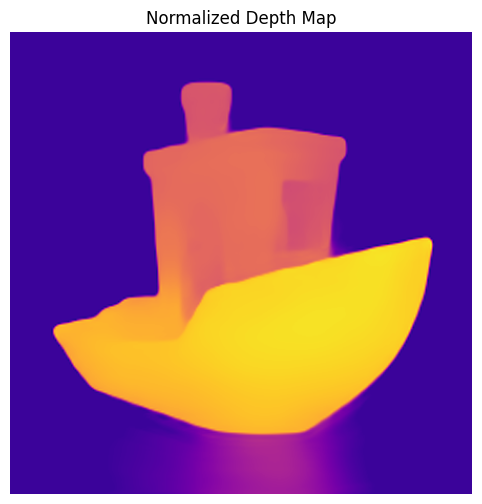

STL file saved as model/openAI/michele_depth_model_detailed_openai.stl


In [6]:

# Example call with your configuration:
process_image_and_generate_stl(
    "image/3dbenchy.png", 
    scale=100,                   # Increase for thicker layers
    stl_filename="model/openAI/michele_depth_model_detailed_openai.stl", 
    downscale_factor=1,          # Retain maximum detail
    num_color_clusters=6,        # Finer color segmentation
    detail_scale=10.0,           # Thicker detail per cue
    depth_layers=3,              # Broader depth layers
    weight_lap=0.3,              # Weight for Laplacian detail
    weight_edge=0.4,             # Weight for edge-based detail to boost key features
    base_thickness=4,            # Solid base thickness for support
    xy_scale=2                   # Spread out grid to avoid compactness
)